# 1. Analysis of Nashville Reviews


In [1]:
# Loading required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import string #for punctuation
from pycontractions  import Contractions
# import swifter
from emoji import replace_emoji
import re
import pattern
from pattern.en import lemma
from keybert import KeyBERT
import json
from wordcloud import WordCloud
import ast
from collections import Counter

## Reading Reviews

In [2]:
# Merge 4 quarters reviews data
df_reviews = pd.read_csv('./data_after_processing/reviews_related_data/processed_reviews.csv', parse_dates=['date'])
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,scrape_date
0,40982948,467396323893639800,2021-10-06,90673403,Ella,"Amazing stay! Exactly what I needed, met a cou...",2022-09-15
1,17736058,459563084,2019-05-27,44997966,Shawn,Cute and quirky little garage apartment in a q...,2022-09-15
2,18731801,571810679,2019-12-01,279173217,Doreen,"Beautiful, clean, close to downtown and fabulo...",2022-09-15
3,18731801,578044495,2019-12-16,314573512,Brianna,"Love this house! Scott and Stefi were great, r...",2022-09-15
4,18731801,613224529,2020-03-01,45475422,Fran,"Beautiful home, convenient location, friendly ...",2022-09-15


In [3]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547803 entries, 0 to 547802
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     547803 non-null  int64         
 1   id             547803 non-null  int64         
 2   date           547803 non-null  datetime64[ns]
 3   reviewer_id    547803 non-null  int64         
 4   reviewer_name  547802 non-null  object        
 5   comments       547803 non-null  object        
 6   scrape_date    547803 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 29.3+ MB


**Pre-Processing of the text**

In [5]:
# https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
# Pycontractions model
cont = Contractions('GoogleNews-vectors-negative300.bin')
cont.load_models()

In [6]:
# Creating the Function to carry out the pre-processing of the text
def clean(text):
    # Convert to lowercase
    text = text.lower()

    # Remove line breaks
    text = text.replace('<br/>', '')

    # Replace emoji
    text = replace_emoji(text, '')

    # There are some special character's in the like - .itÃªs, so we will remove the non-ASCII characters
    text = re.sub('[^\x00-\x7F]+' , "'", text)

    # Fix contractions
    text = list(cont.expand_texts([text], precise=True))[0]

    # Remove punctuations
    text = "".join([i for i in text if i not in string.punctuation])

    # Lemmatize
    text = ' '.join([lemma(word) for word in text.split()])

    return text

In [ ]:
# Apply the pre-processing function to the comments
df_reviews['clean_comments'] = df_reviews['comments'].apply(clean)

# # Write to CSV to recover later --> this will have the clean comments
# df_reviews.to_csv('comments.csv', index=False)

In [28]:
# Before looping through the dataframe --> df_reviews convert it into dictionary format to speed the looping process
df_dict = df_reviews.to_dict(orient='records')
# Using KeyBERT algorithm to extract keyphrases
kw_model = KeyBERT()
# Create main list containing list of keyphrases from all the comments
keyphrases = []
# This will be used to create the final dataframe
full_data_list = []
for row in df_dict: 
    # Retrieving key phrases for each review            
    k = kw_model.extract_keywords(row['clean_comments'],keyphrase_ngram_range=(1,2),stop_words='english') 
    keyphrases += list(map(lambda a : a[0], k)) 
    # Add all the columns of the reviews dataframe and add the keyphrases column to it
    full_data_list.append(list(row.values()) + [json.dumps(k)])   

df_reviews_keyphrases_data = pd.DataFrame(data=full_data_list , columns = list(df_reviews.columns) + ['keyphrases'])

# Populating the file which has blank clean comments
df_reviews_keyphrases_data.loc[(df_reviews_keyphrases_data['clean_comments'].isna()) | (df_reviews_keyphrases_data['clean_comments'] == ''), :] \
                                                                            .to_csv('./data_after_processing/reviews_related_data/blank_clean_comment_keyphrasefile.csv')

# This file will have the clean comments along with the keyphrases. There were some comments where there were just . or multiple emojis or non-ASCII characters etc, so those need to be removed
idx_to_drop = df_reviews_keyphrases_data.loc[(df_reviews_keyphrases_data['clean_comments'].isna()) | (df_reviews_keyphrases_data['clean_comments'] == ''), :].index

df_reviews_keyphrases_data.drop(index = idx_to_drop , axis = 0, inplace = True)
df_reviews_keyphrases_data.to_csv('./data_after_processing/reviews_related_data/comments_with_keyphrases.csv', index=False)

## Generating Word Cloud (what people are saying about a particular listing)

In [2]:
# Read the keyphrase file saved
df_keyphrase = pd.read_csv('./data_after_processing/reviews_related_data/comments_with_keyphrases.csv')
df_keyphrase.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,scrape_date,clean_comments,keyphrases
0,40982948.0,4.673960e+17,2021-10-06,90673403,Ella,"Amazing stay! Exactly what I needed, met a cou...",9/15/2022,amaze stay exactly what i need meet a couple o...,"[[""guest travele"", 0.5552], [""amaze stay"", 0.4..."
1,17736058.0,4.595631e+08,2019-05-27,44997966,Shawn,Cute and quirky little garage apartment in a q...,9/15/2022,cute and quirky little garage apartment in a q...,"[[""quiet residential"", 0.5248], [""walkway door..."
2,18731801.0,5.718107e+08,2019-12-01,279173217,Doreen,"Beautiful, clean, close to downtown and fabulo...",9/15/2022,beautiful clean close to downtown and fabulou ...,"[[""downtown fabulou"", 0.7631], [""fabulou host""..."
3,18731801.0,5.780445e+08,2019-12-16,314573512,Brianna,"Love this house! Scott and Stefi were great, r...",9/15/2022,love thi house scott and stefi be great reply ...,"[[""clean bed"", 0.5452], [""hotel"", 0.4859], [""b..."
4,18731801.0,6.132245e+08,2020-03-01,45475422,Fran,"Beautiful home, convenient location, friendly ...",9/15/2022,beautiful home convenient location friendly ho...,"[[""location friendly"", 0.6076], [""home conveni..."


In [3]:
# Retrieve the keyphrase portion of all the rows (not the score value)
def extract_keyphrase_word(iterable):
    return list(map(lambda a : a[0] , ast.literal_eval(iterable)))

df_keyphrase['keyphrase_words'] = df_keyphrase['keyphrases'].apply(extract_keyphrase_word)

In [4]:
# Remove the single word nashville and airbnb
words_list_remove = ['nashville','airbnb']
df_keyphrase['keyphrase_words1'] = df_keyphrase['keyphrase_words'].\
    apply(lambda word : [a for a in word if a not in words_list_remove]) 

In [5]:
# Combine all the keyphrases listing wise 
def combine_keyphrases(series):    
    return series.explode().tolist()
df_new = df_keyphrase.groupby('listing_id',as_index=False).agg({'keyphrase_words1' : combine_keyphrases})
df_new.to_csv('rand3.csv', index=False)

In [6]:
# Create the function to which listing_id will be passed and the word cloud will be generated
def create_wordcloud(listing_id_iter):
    cnt = 0
    fig, ax = plt.subplots(nrows = len(listing_id_iter), figsize=(20,30))
    # Create the word cloud instance
    cloud = WordCloud(background_color = "white", 
                            collocations=False
                    )
    for id in listing_id_iter:        
        # First convert the series of keyphrases to list
        x= list(df_new[df_new['listing_id']== id]['keyphrase_words1'])
        # Flatten the list (from the above step we will get list of list)       
        x = [item  for i in x for item in i]
        
        # Create the word cloud from the frequencies --> get frequencies of phrases from the Counter()                     
        wc = cloud.generate_from_frequencies(Counter(x))
        ax[cnt].imshow(wc)
        ax[cnt].axis('off')
        cnt += 1

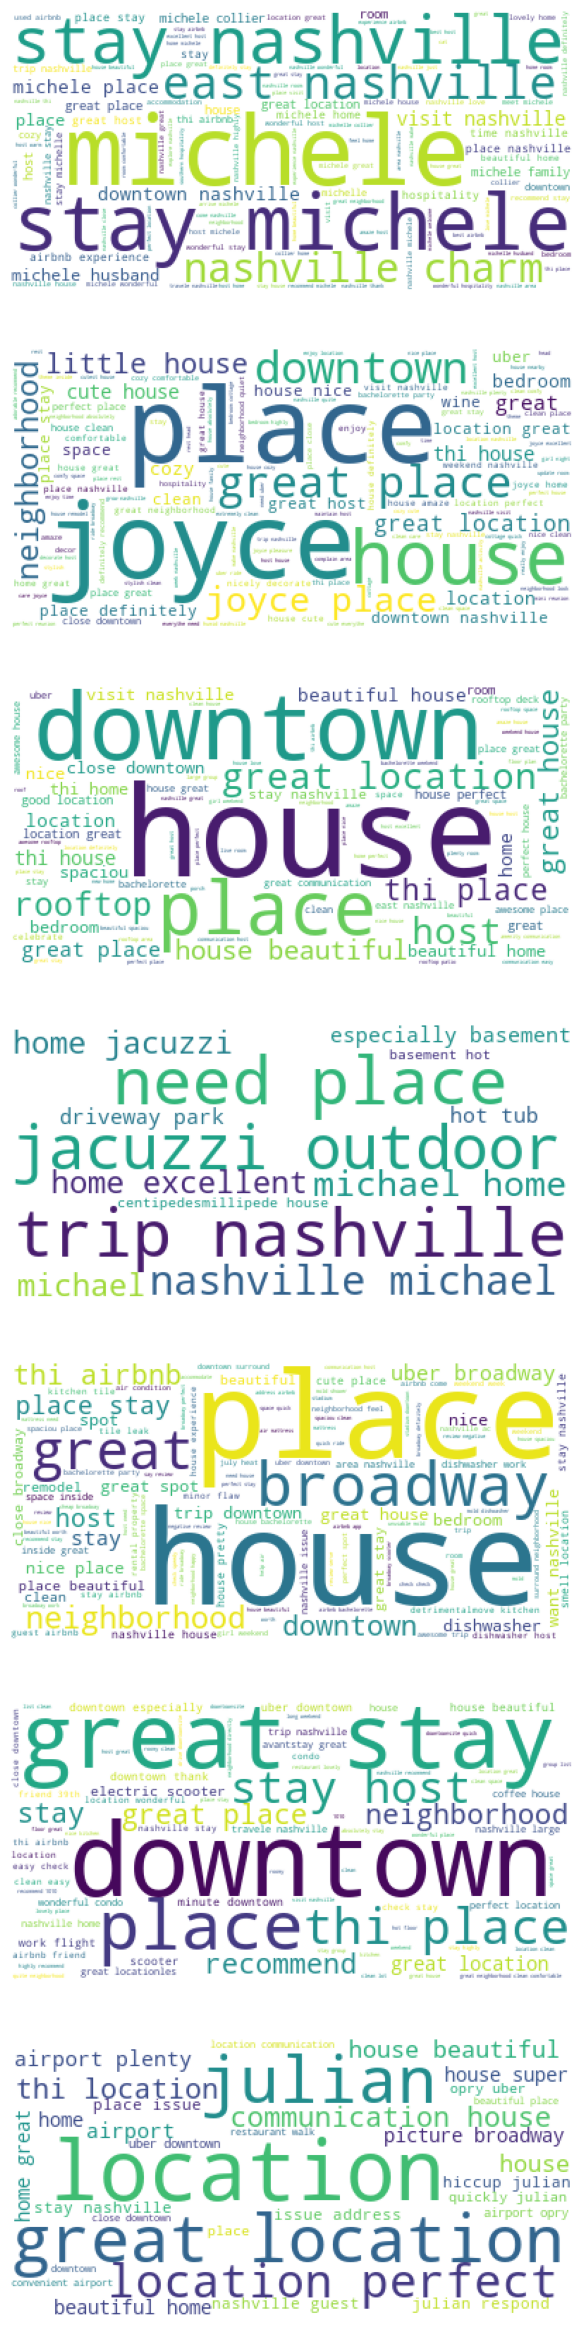

In [7]:
# Listing (53187924) is different as it says it is available but do not show up in airbnb website. It might be this listing
# has been taken down. There are other listings also with one or two reviews (but do show up on the airbnb website),
# it could be they are newly added and not much people know about it
# create_wordcloud([53187924,72906])
create_wordcloud([6422,20616153,23825123,656711000000000000,40485713,47181950,676223000000000000])  #df_new.iloc[0:20,0].tolist()